In [ ]:
#Jupyter de execução da implenetação final do modelo, já a partir da base final

In [1]:
#importar pandas
import pandas as pd

#importar conexão com mySQL
import mysql.connector

#impotar a função mean do numpy (cálculo de médias)
from numpy import mean

#importa o matplotlib (plotagem de gráficos)
import matplotlib.pyplot as plt

#importa a funçao train_test_split, para separar o dataset em dados de teste e dados de treinamento
from sklearn.model_selection import train_test_split

#importa o algoritmo KNN (K nearest neighbors) e ferramentas de medição do resultado (metrics)
from sklearn import neighbors, metrics

#importar o SVM (Support Vector Machine)
from sklearn import svm

#importa o Naive Bayes
from sklearn.naive_bayes import GaussianNB

#importa Regressão Logística
from sklearn.linear_model import LogisticRegression

#importa a Árvore de Decisão
from sklearn.ensemble import RandomForestClassifier

#importa a matriz de confusão e o relatório de classificação do scikit
from sklearn.metrics import confusion_matrix, classification_report

#importa o método cross_val_score para a aplicação de cross validation na base de dados
from sklearn.model_selection import cross_val_score

#importa o stats para aplicação de cálculos estatísticos
import scipy.stats as stats

#importa contador do Python, para medição dos resultados de classes de variável
from collections import Counter

#importa SMOTE da biblioteca imblearn, para aplicação de Oversampling na base de treino
from imblearn.over_sampling import SMOTE

#importa RandomUnderSampler da biblioteca imblearn, para aplicação de Undersampling na base de treino
from imblearn.under_sampling import RandomUnderSampler

#importa o RepeatedStratifiedKFold para aplicação repetida de particionamentos de validação cruzada na base de dados
from sklearn.model_selection import RepeatedStratifiedKFold

#importa Pipeline da imblearn, para aplicação das estratégias de Resampling
from imblearn.pipeline import Pipeline

In [2]:
# aplicação do método ISO de encoding, uma vez que o padrão UTF-8 não se apresentou compatível, acusando erros de 
# carregamento
# df = pd.read_csv(r"C:\Users\Luiza\Desktop\BasesTCC\cadastro.csv", sep=';', encoding='ISO-8859-1')

In [3]:
db = mysql.connector.connect(
    host = "localhost",
    user = "root",
    passwd="mydbwork",
    db = "puc")


In [4]:
mycursor = db.cursor()

mycursor.execute("""SELECT  Cod_Assunto, Gestor, sol, contagem, prazo_medio,
                    uf_id, VL_REND_LQDO, idade, COD_GRAU_INST, COD_ETDO_CVIL, Bacen FROM base_unificada""")
dados = mycursor.fetchall()


In [5]:
df = pd.DataFrame(dados, columns=['Assunto', 'Gestor', 'Solucao', 'Contagem', 'Prazo', 'UF', 'Renda',
                                  'Idade', 'Escolaridade', 'Estado_Civil', 'Bacen'])

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24858 entries, 0 to 24857
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Assunto       24858 non-null  int64  
 1   Gestor        24858 non-null  int64  
 2   Solucao       24858 non-null  int64  
 3   Contagem      24858 non-null  int64  
 4   Prazo         24858 non-null  int64  
 5   UF            24858 non-null  int64  
 6   Renda         24848 non-null  float64
 7   Idade         24858 non-null  int64  
 8   Escolaridade  24858 non-null  int64  
 9   Estado_Civil  24858 non-null  int64  
 10  Bacen         24858 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 2.1 MB


In [231]:
df.head(3)

,Assunto,Gestor,Solucao,Contagem,Prazo,UF,Renda,Idade,Escolaridade,Estado_Civil,Bacen
0,21104,9973,1,1,5,1,3.0,54,3,1,0
1,21349,8869,1,1,7,12,1.0,82,3,1,0
2,20050,9880,1,2,8,1,3.0,84,5,1,0


In [232]:
df.isnull().sum()

Assunto          0
Gestor           0
Solucao          0
Contagem         0
Prazo            0
UF               0
Renda           10
Idade            0
Escolaridade     0
Estado_Civil     0
Bacen            0
dtype: int64

In [233]:
df[["Renda"]].isnull().all(axis=1).sum()

10

In [234]:
df['Renda'] = df['Renda'].fillna(0)

In [235]:
df.isnull().sum()

Assunto         0
Gestor          0
Solucao         0
Contagem        0
Prazo           0
UF              0
Renda           0
Idade           0
Escolaridade    0
Estado_Civil    0
Bacen           0
dtype: int64

In [236]:
# Ajustar Renda

In [237]:
df = df.set_index(["Idade", "Escolaridade"])

In [238]:
df["Media"] = df.groupby(["Idade", "Escolaridade"]).agg({"Renda": "mean"})

In [239]:
df = df.reset_index()

In [240]:
#ajuste de todos os nulls e 0 (zeros) em renda, a partir da média de renda encontrada entre o grupo de mesma idade e
#escolaridade
for row in df.itertuples():
    if pd.isnull(row.Renda) or row.Renda ==0:
        df.at[row.Index, "Renda"] = df.at[row.Index,"Media"]     
    else:
        pass

In [241]:
df.head(200).sort_values("Renda", ascending = False, na_position = "first")

,Idade,Escolaridade,Assunto,Gestor,Solucao,Contagem,Prazo,UF,Renda,Estado_Civil,Bacen,Media
117,46,3,21162,8596,1,1,10,1,7.0,1,0,1.863636
94,45,3,20905,9973,1,3,0,25,7.0,1,0,1.938144
68,52,3,20051,9973,1,1,0,28,6.0,1,0,2.106742
10,78,5,21282,8008,1,1,6,1,6.0,1,0,3.838710
121,82,5,21507,9973,1,1,6,1,6.0,1,0,3.263158
...,...,...,...,...,...,...,...,...,...,...,...,...
123,80,2,21518,9973,1,1,3,12,1.0,1,0,2.000000
39,74,2,21457,9973,1,1,13,25,1.0,1,0,1.603774
120,54,2,21264,8593,1,1,8,25,1.0,1,0,1.631579
119,70,2,21157,8596,1,1,7,25,1.0,1,0,1.486842


In [242]:
df[["Renda"]].isnull().all(axis=1).sum()

0

In [243]:
#471 campos ajustados com a estratégia de agrupamento por grau de de instrução e idade
df[df["Renda"]==df["Media"]]

,Idade,Escolaridade,Assunto,Gestor,Solucao,Contagem,Prazo,UF,Renda,Estado_Civil,Bacen,Media
91,96,3,21457,9973,1,1,17,7,2.0,1,0,2.0
111,60,8,21518,9973,1,2,26,25,4.0,1,0,4.0
167,77,0,20001,9880,1,1,2,12,1.0,1,0,1.0
184,38,8,21595,8008,0,4,6,1,3.0,3,1,3.0
239,58,0,21259,9951,1,1,7,12,1.0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
24612,24,0,21121,9973,1,2,0,12,1.0,0,0,1.0
24626,19,9,21487,9973,1,2,0,7,1.0,1,0,1.0
24630,19,9,20936,9973,1,1,0,24,1.0,1,0,1.0
24646,79,6,21457,9973,0,2,9,7,4.0,1,0,4.0


In [244]:
df = df.drop("Media", 1)

In [7]:
mask1 = df["Gestor"] == 0
mask2 = df["Assunto"] == 0
mask3 = df["UF"] == 0

df[mask1 | mask2 | mask3] 

,Assunto,Gestor,Solucao,Contagem,Prazo,UF,Renda,Idade,Escolaridade,Estado_Civil,Bacen


In [247]:
df["UF"] = df["UF"].astype('int')

In [248]:
df["Renda"] = df["Renda"].astype('int')

In [249]:
df["Gestor"] = df["Gestor"].astype('int')

In [250]:
df["Renda"] = df["Renda"].astype('int')

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24858 entries, 0 to 24857
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Idade         24858 non-null  int64
 1   Escolaridade  24858 non-null  int64
 2   Assunto       24858 non-null  int64
 3   Gestor        24858 non-null  int32
 4   Solucao       24858 non-null  int64
 5   Contagem      24858 non-null  int64
 6   Prazo         24858 non-null  int64
 7   UF            24858 non-null  int32
 8   Renda         24858 non-null  int32
 9   Estado_Civil  24858 non-null  int64
 10  Bacen         24858 non-null  int64
dtypes: int32(3), int64(8)
memory usage: 1.8 MB


In [252]:
df.tail(25)

,Idade,Escolaridade,Assunto,Gestor,Solucao,Contagem,Prazo,UF,Renda,Estado_Civil,Bacen
24833,35,5,20004,9880,1,1,2,5,4,1,0
24834,34,3,20938,9973,1,1,0,9,1,1,0
24835,34,5,21157,8596,1,2,4,19,3,1,0
24836,49,5,21151,9973,0,2,15,7,2,3,0
24837,55,3,21081,9973,0,1,6,24,3,1,0
24838,32,5,20052,9880,0,2,9,12,3,1,0
24839,61,5,21085,9973,0,1,7,7,1,3,0
24840,48,5,21518,9973,0,2,5,12,5,1,1
24841,35,3,20960,9973,0,1,7,7,3,1,0
24842,50,9,20052,9880,0,1,4,12,2,3,0


<AxesSubplot:>

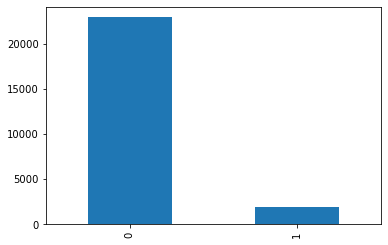

In [253]:
df['Bacen'].value_counts().plot(kind='bar')

In [218]:
correlacao = df.corr()
correlacao.style.background_gradient(cmap='YlOrRd').set_precision(3)

,Idade,Escolaridade,Assunto,Gestor,Solucao,Contagem,Prazo,UF,Renda,Estado_Civil,Bacen
Idade,1.000,-0.205,0.079,-0.068,-0.077,-0.004,0.147,-0.064,0.269,0.215,0.001
Escolaridade,-0.205,1.000,-0.022,0.011,-0.065,-0.028,0.080,-0.029,0.162,-0.005,0.092
Assunto,0.079,-0.022,1.000,-0.281,-0.059,-0.006,0.067,0.001,0.010,0.035,0.025
Gestor,-0.068,0.011,-0.281,1.000,0.013,0.005,-0.047,-0.006,-0.025,0.000,0.037
Solucao,-0.077,-0.065,-0.059,0.013,1.000,-0.043,-0.198,0.026,-0.117,-0.326,-0.499
Contagem,-0.004,-0.028,-0.006,0.005,-0.043,1.000,-0.045,0.002,-0.015,0.033,0.194
Prazo,0.147,0.080,0.067,-0.047,-0.198,-0.045,1.000,-0.022,0.129,0.062,0.133
UF,-0.064,-0.029,0.001,-0.006,0.026,0.002,-0.022,1.000,-0.093,-0.068,-0.028
Renda,0.269,0.162,0.010,-0.025,-0.117,-0.015,0.129,-0.093,1.000,0.102,0.102
Estado_Civil,0.215,-0.005,0.035,0.000,-0.326,0.033,0.062,-0.068,0.102,1.000,0.243


In [219]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [222]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3)

In [224]:
#teste de hipóteses T-Student (2 sample) de y (variável Bacen), nas bases de treino e teste
stats.ttest_ind(a = y_train, b = y_test)


Ttest_indResult(statistic=0.11582054912708911, pvalue=0.9077956999025234)

In [254]:
#definição dos Algoritmos a serem utilizados
modelos = [LogisticRegression(), svm.LinearSVC(dual=False),\
           neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform'), \
           RandomForestClassifier(n_estimators=300, class_weight={0:1, 1:30}, criterion="entropy"), GaussianNB()]
nomes = ['Logistic Regression','SVC', 'KNC','Random Forest', 'Naive Bayes']

In [255]:
#Definição da Resampling
Bacen1_treino_ajuste = SMOTE(sampling_strategy=0.2)
Bacen0_treino_ajuste = RandomUnderSampler(sampling_strategy=0.5)

In [256]:
#Parâmetros da Validação Cruzada (10 subdivisões e 3 repetições)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [257]:
#Definição de X (variáveis preditivas) e y (variável de interesse) para alimentar os modelos
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [258]:
for modelos, nomes in zip(modelos, nomes):
    steps = [('oversampling', Bacen1_treino_ajuste), ('undersampling', Bacen0_treino_ajuste), ('Algoritmo', modelos)]
    pipeline = Pipeline(steps=steps)
    print("")
    print(nomes)
    print("-"*(len(nomes)))
    pre= cross_val_score(pipeline, X, y, scoring='precision', cv=cv, n_jobs=-1).mean()
    rec= cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1).mean()
    print("Precision:", pre)
    print("Recall:", rec)
    print("F2-Measure :", 5*pre*rec/((4*pre)+rec))


Logistic Regression
-------------------
Precision: 0.3937467598572144
Recall: 0.7683575645431316
F2-Measure : 0.6455266991842206

SVC
---
Precision: 0.3878470485565817
Recall: 0.7875425147590097
F2-Measure : 0.6529608568323454

KNC
---
Precision: 0.2508137637201585
Recall: 0.5668684465591681
F2-Measure : 0.45276186390856193

Random Forest
-------------
Precision: 0.7751163248915508
Recall: 0.8828927658824566
F2-Measure : 0.859004619619936

Naive Bayes
-----------
Precision: 0.39240066856302486
Recall: 0.7715939730372721
F2-Measure : 0.6466222972546468


In [169]:
mycursor.close()
db.close

<bound method MySQLConnection.close of <mysql.connector.connection.MySQLConnection object at 0x0000025F964FA0B8>>